In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

def load_triggers(df, hg_threshold):
    triggers = []
    total_triggers = len(df) // 64

    for i in tqdm(range(total_triggers), desc="Processing triggers"):
        block = df.iloc[i*64:(i+1)*64]
        timestamp = block["Tstamp_us"].iloc[0]
        active_channels = block[block["HG"] > hg_threshold]["Ch"].values
        triggers.append({"timestamp": timestamp, "channels": active_channels})

    return triggers

def match_triggers(triggers_D1, triggers_D2, tolerance=10):
    coincidences = []
    i, j = 0, 0
    while i < len(triggers_D1) and j < len(triggers_D2):
        t1 = triggers_D1[i]["timestamp"]
        t2 = triggers_D2[j]["timestamp"]
        dt = t1 - t2
        if abs(dt) <= tolerance:
            coincidences.append((triggers_D1[i], triggers_D2[j]))
            i += 1
            j += 1
        elif dt < 0:
            i += 1
        else:
            j += 1
    return coincidences

def calc_eff(C_muon, C_muon_plus):
        eff = {}
        for ch in C_muon:
            total = C_muon[ch]
            plus = C_muon_plus[ch]
            if total > 0:
                eff[ch] = plus / total
            else:
                eff[ch] = np.nan
        return eff

def calculate_efficiency(df_D1, df_D2, hg_threshold, X_D1, Y_D1, X_D2, Y_D2, match=True, tolerance=10):
    triggers_D1 = load_triggers(df_D1, hg_threshold)
    triggers_D2 = load_triggers(df_D2, hg_threshold)

    if match:
        coincidences = match_triggers(triggers_D1, triggers_D2, tolerance)
    else:
        coincidences = list(zip(triggers_D1, triggers_D2))

    C_muon_i = {ch: 0 for ch in X_D1}
    C_muon_plus_i = {ch: 0 for ch in X_D1}
    C_muon_j = {ch: 0 for ch in Y_D1}
    C_muon_plus_j = {ch: 0 for ch in Y_D1}

    C_muon_i_D2 = {ch: 0 for ch in X_D2}
    C_muon_plus_i_D2 = {ch: 0 for ch in X_D2}
    C_muon_j_D2 = {ch: 0 for ch in Y_D2}
    C_muon_plus_j_D2 = {ch: 0 for ch in Y_D2}

    for pair in tqdm(coincidences, desc="Processing coincidences"):
        channels_D1 = pair[0]["channels"]
        channels_D2 = pair[1]["channels"]

        set_D1 = set(channels_D1)
        set_D2 = set(channels_D2)

        for i in X_D1:
            for j in Y_D1:

                #Conditions for iD1

                cond1_i1 = (i - 1 in set_D1 or i + 1 in set_D1)
                cond2_i1 = (j in set_D1 and (j - 1 in set_D1 or j + 1 in set_D1))
                cond3_i1 = (i in set_D2 and (i - 1 in set_D2 or i + 1 in set_D2))
                cond4_i1 = (j in set_D2 and (j - 1 in set_D2 or j + 1 in set_D2))

                if cond1_i1 and cond2_i1 and cond3_i1 and cond4_i1:
                    C_muon_i[i] += 1
                    if i in set_D1:
                        C_muon_plus_i[i] += 1

                #Conditions for iD2

                cond1_i2 = (i - 1 in set_D2 or i + 1 in set_D2)
                cond2_i2 = (j in set_D2 and (j - 1 in set_D2 or j + 1 in set_D2))
                cond3_i2 = (i in set_D1 and (i - 1 in set_D1 or i + 1 in set_D1))
                cond4_i2 = (j in set_D1 and (j - 1 in set_D1 or j + 1 in set_D1))

                if cond1_i2 and cond2_i2 and cond3_i2 and cond4_i2:
                    C_muon_i_D2[i] += 1
                    if i in set_D2:
                        C_muon_plus_i_D2[i] += 1

                #Conditions for jD1

                cond1_j1 = (j - 1 in set_D1 or j + 1 in set_D1)
                cond2_j1 = (i in set_D1 and (i - 1 in set_D1 or i + 1 in set_D1))
                cond3_j1 = (j in set_D2 and (j - 1 in set_D2 or j + 1 in set_D2))
                cond4_j1 = (i in set_D2 and (i - 1 in set_D2 or i + 1 in set_D2))

                if cond1_j1 and cond2_j1 and cond3_j1 and cond4_j1:
                    C_muon_j[j] += 1
                    if j in set_D1:
                        C_muon_plus_j[j] += 1
                
                #Conditions for jD2

                cond1_j2 = (j - 1 in set_D2 or j + 1 in set_D2)
                cond2_j2 = (i in set_D2 and (i - 1 in set_D2 or i + 1 in set_D2))
                cond3_j2 = (j in set_D1 and (j - 1 in set_D1 or j + 1 in set_D1))
                cond4_j2 = (i in set_D1 and (i - 1 in set_D1 or i + 1 in set_D1))

                if cond1_j2 and cond2_j2 and cond3_j2 and cond4_j2:
                    C_muon_j_D2[j] += 1
                    if j in set_D2:
                        C_muon_plus_j_D2[j] += 1

    efficiency_i = calc_eff(C_muon_i, C_muon_plus_i)
    efficiency_j = calc_eff(C_muon_j, C_muon_plus_j)
    efficiency_i_D2 = calc_eff(C_muon_i_D2, C_muon_plus_i_D2)
    efficiency_j_D2 = calc_eff(C_muon_j_D2, C_muon_plus_j_D2)

    effs = [efficiency_i, efficiency_j, efficiency_i_D2, efficiency_j_D2]
    C_muon = [C_muon_i, C_muon_j, C_muon_i_D2, C_muon_j_D2]
    C_muon_plus = [C_muon_plus_i, C_muon_plus_j, C_muon_plus_i_D2, C_muon_plus_j_D2]

    return effs, C_muon, C_muon_plus

def plot_efficiency_vs_channel(efficiency, title="Efficiency vs Channel"):
    channels = np.array(sorted(efficiency.keys()))
    values = np.array([efficiency.get(ch, np.nan) for ch in channels])

    avg = np.nanmean(values)
    std = np.nanstd(values)

    plt.figure(figsize=(15, 5))
    plt.scatter(channels, values, label=f"Std dev: {std:.3f}")
    plt.axhline(avg, color='r', linestyle='--', label=f"Mean: {avg:.3f}")
    plt.title(title)
    plt.xlabel("Channel")
    plt.ylabel("Efficiency")
    plt.xticks(np.arange(min(channels), max(channels)+1, 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_event_counts_per_channel(C_muon_dict, title="Muon-pattern Event Counts per Channel"):
    channels = sorted(C_muon_dict.keys())
    counts = [C_muon_dict[ch] for ch in channels]

    plt.figure(figsize=(15, 5))
    plt.bar(channels, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Channel")
    plt.ylabel("Number of Events (C_muon)")
    plt.xticks(np.arange(min(channels), max(channels)+1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [7]:
df1 = pd.read_parquet("Toma_MatrizDependiente.parquet", engine='pyarrow')
df1 = df1.drop(['Brd', 'LG'], axis=1)

df2 = pd.read_parquet("Toma_MatrizLider.parquet", engine='pyarrow')
df2.rename(columns={'Ch': 'LG', 'LG':'Ch',}, inplace=True)
df2 = df2.drop(['Brd', 'LG'], axis=1)

In [8]:
X_D1 = list(range(0, 29))
Y_D1 = list(range(32, 61))
X_D2 = list(range(0, 29))
Y_D2 = list(range(32, 61))

hg_threshold = 1000

effs, C_muonsi, C_muons_plusi = calculate_efficiency(
    df1, df2,
    hg_threshold,
    X_D1, Y_D1, X_D2, Y_D2,
    match=False
)

Processing coincidences: 100%|██████████| 10000/10000 [00:07<00:00, 1318.11it/s]


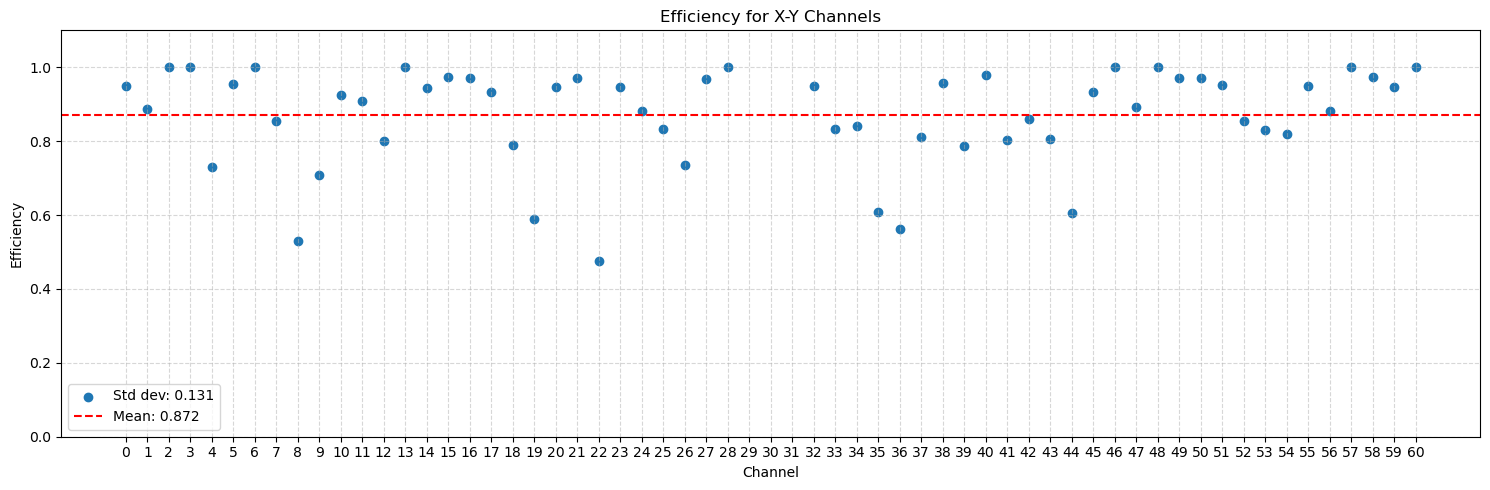

In [9]:
eff = {**effs[0], **effs[1]}

plot_efficiency_vs_channel(eff, title="Efficiency for X-Y Channels")

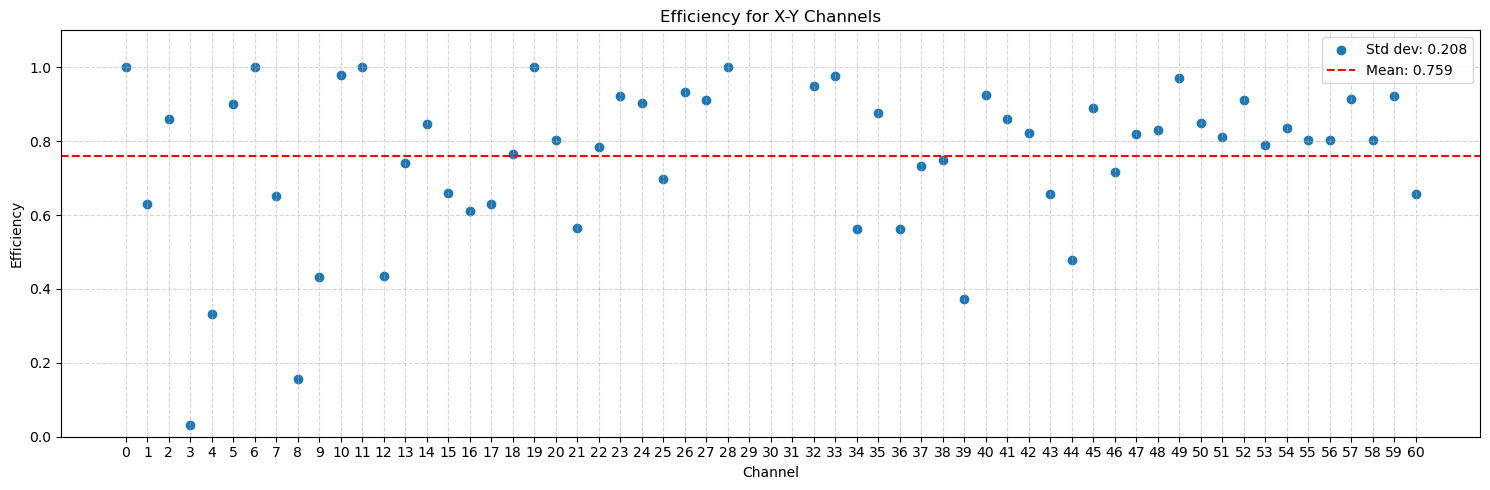

In [10]:
eff = {**effs[2], **effs[3]}

plot_efficiency_vs_channel(eff, title="Efficiency for X-Y Channels")

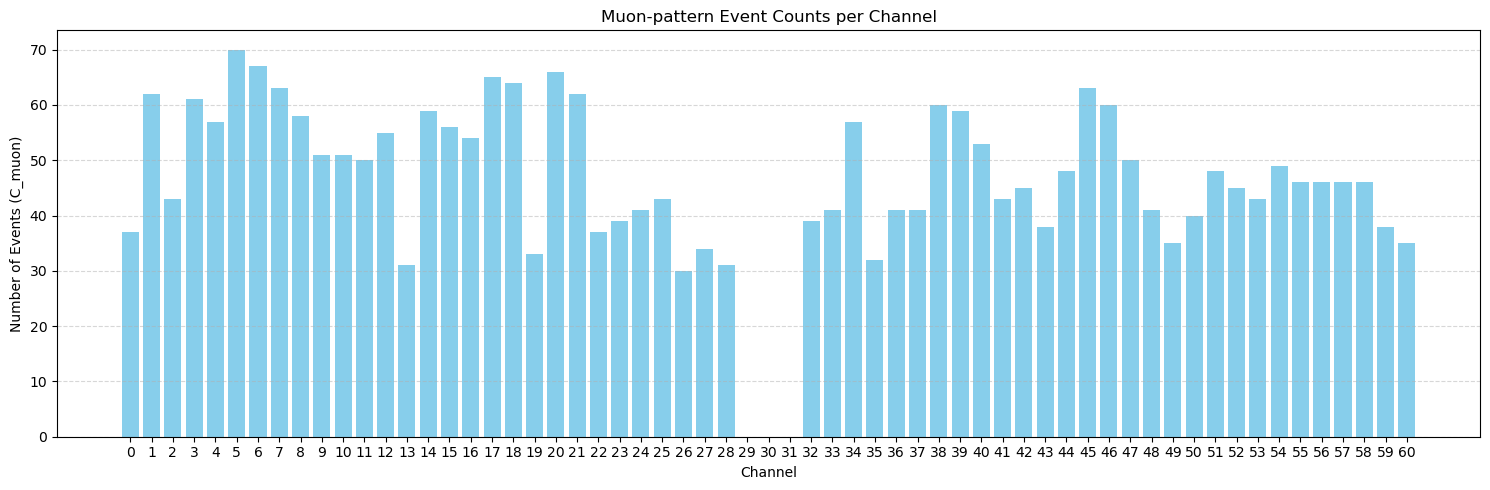

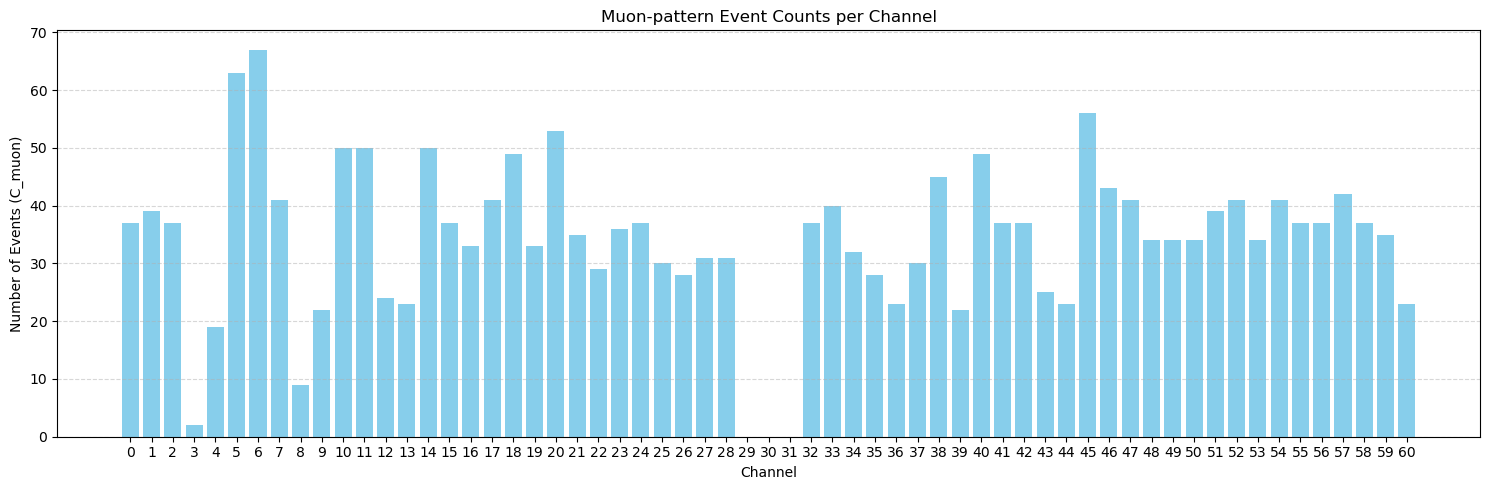

In [14]:
plot_event_counts_per_channel({**C_muonsi[2], **C_muonsi[3]})
plot_event_counts_per_channel({**C_muons_plusi[2], **C_muons_plusi[3]})